<a href="https://colab.research.google.com/github/zengdard/MistralFineTune_Mixtral_7x8B_Image_To_Text/blob/main/mistralfinetune_mixtral_7x8b_image_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies

In [ ]:
! pip install datasets mistralai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall

## Download Dataset from HF

In [ ]:
from datasets import load_dataset
dataset = load_dataset('kopyl/833-icons-dataset-1024-blip-large')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

## Convert Image to Text with Ascii Characters

In [ ]:
import json
import PIL
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
# ASCII characters used to build the output text
ASCII_CHARS = list("$@%&#*/\1{}?-_+~<>i!I;:,\"^`'. ")

def resize_image(image, new_width=80):
    width, height = image.size
    ratio = height / width
    new_height = int(new_width * ratio)
    resized_image = image.resize((new_width, new_height))
    return resized_image

def grayify(image):
    grayscale_image = image.convert("L")
    return grayscale_image

def pixels_to_ascii(image):
    pixels = image.getdata()
    ascii_str = "".join([ASCII_CHARS[pixel * (len(ASCII_CHARS) - 1) // 255] for pixel in pixels])
    return ascii_str

def image_to_ascii(image, new_width=80):
    gray_image = grayify(resize_image(image, new_width))
    ascii_str = pixels_to_ascii(gray_image)
    pixel_count = len(ascii_str)
    ascii_image = "\n".join([ascii_str[index:(index + new_width)] for index in range(0, pixel_count, new_width)])
    return ascii_image


# Convert dataset to conversational JSONL format
jsonl_data = []
x = 0
for entry in dataset['train']:
  ascii_art = image_to_ascii(entry['image']).replace('                                                                                ', '')
  messages = [
      {"role": "user", "content": ascii_art
},
      {"role": "assistant", "content": entry['text']}
  ]
  jsonl_entry = {"messages": messages}
  jsonl_data.append(jsonl_entry)

# Save to JSONL file
with open('fine_tune_data.jsonl', 'w+') as jsonl_file:
    for entry in jsonl_data:
        jsonl_file.write(json.dumps(entry) + '\n')

print("Conversion and JSONL file creation completed.")


Conversion and JSONL file creation completed.


In [ ]:
print(ascii_art)   ##Print last one for example
















                                             .'`^^`.`.                          
                                           '^^`'... .                           
                                         '^`.                                   
                                       .^`.   '`^^^^^`'.                        
                                      `^'  .`^^''....'`^`.                      
                                    .`^. .`^'.         .'"'                     
                                    '`  '^`   .'^^^^^`.  .^`                    
                                       '^.  '^^`'....'^^.  ^`                   
                  .,".                '^. .^^' '  ^'   '^'  ^'                  
                 .,ii^               '^. ."'   '^^'     .^' .^.                 
                .:!!!!,             .". .".     ",.    ''.". `'                 
                .!i!!iI.            ^' ."..   .^''^.  `^. '` .^                 
             

## Save and Make the Train & Valid dataset

In [ ]:
import os
import json
import random

input_file_path = 'fine_tune_data.jsonl'

# Paths for output files
train_file_path = 'train.jsonl'
valid_file_path = 'valid.jsonl'

# Read data from JSONL file
with open(input_file_path, 'r') as f:
    data = [json.loads(line) for line in f]

# Shuffle the data
random.shuffle(data)

split_index = int(len(data) * 0.98)

valid_data = data[split_index:]   # The last 80% of the data for training
train_data = data[:split_index]

# Save the data to output files
with open(train_file_path, 'w+') as f:
    for item in train_data:
        f.write(json.dumps(item) + '\n')

with open(valid_file_path, 'w+') as f:
    for item in valid_data:
        f.write(json.dumps(item) + '\n')

with open('file.json', 'w+') as f:
    for item in valid_data:
        f.write(json.dumps(item) + '\n')

print('Files have been successfully split and saved.')


Files have been successfully split and saved.


In [ ]:
print(len(valid_data), len(train_data))  ##

17 816


## Upload to Mistral Api

In [ ]:
import os
from mistralai.client import MistralClient

api_key = ''
client = MistralClient(api_key=api_key)

with open("train.jsonl", "rb") as f:
    training_data = client.files.create(file=("train.jsonl", f))
with open("valid.jsonl", "rb") as f1:
    valid_mistral_data = client.files.create(file=("valid.jsonl", f1))

In [ ]:
print(valid_mistral_data, training_data) ## See Weights

id='cef0c3ed-8815-48bc-be69-52e941f20843' object='file' bytes=3418464 created_at=1719052135 filename='valid.jsonl' purpose='fine-tune' id='6e20f43e-6050-48c2-82f2-5a1e096282ef' object='file' bytes=72601 created_at=1719052134 filename='train.jsonl' purpose='fine-tune'


In [ ]:
from mistralai.models.jobs import TrainingParameters, WandbIntegrationIn

wandb_api_key = ''

created_jobs = client.jobs.create(
    model="open-mistral-7b",
    training_files=[training_data.id],
    validation_files=[valid_mistral_data.id],
    hyperparameters=TrainingParameters(
        training_steps=100,
        learning_rate=2.0e-4,  ## Learning rate
        ),

    integrations=[
        WandbIntegrationIn(
            project="Mistral_Text2image",
            run_name="Run_2",
            api_key=wandb_api_key,
        ).dict()
    ]
)

In [ ]:
created_jobs

Job(id='ffa53cd3-60d3-4744-822f-45750a4fe9ec', hyperparameters=TrainingParameters(training_steps=100, learning_rate=0.0002), fine_tuned_model=None, model='open-mistral-7b', status='QUEUED', job_type='FT', created_at=1719052310, modified_at=1719052310, training_files=['cef0c3ed-8815-48bc-be69-52e941f20843'], validation_files=['6e20f43e-6050-48c2-82f2-5a1e096282ef'], object='job', integrations=[WandbIntegration(type='wandb', project='Mistral_Text2image', name=None, run_name='Run_2')])

## Make inference with the FineTune Model

In [ ]:
jobs = client.jobs.list()
retrieved_jobs = client.jobs.retrieve(created_jobs.id)
print(retrieved_jobs)

data=[Job(id='ffa53cd3-60d3-4744-822f-45750a4fe9ec', hyperparameters=TrainingParameters(training_steps=100, learning_rate=0.0002), fine_tuned_model='ft:open-mistral-7b:569ba51c:20240622:ffa53cd3', model='open-mistral-7b', status='SUCCESS', job_type='FT', created_at=1719052310, modified_at=1719052749, training_files=['cef0c3ed-8815-48bc-be69-52e941f20843'], validation_files=['6e20f43e-6050-48c2-82f2-5a1e096282ef'], object='job', integrations=[WandbIntegration(type='wandb', project='Mistral_Text2image', name=None, run_name='Run_2')]), Job(id='4373718c-e3ff-4955-be4e-69373a82792a', hyperparameters=TrainingParameters(training_steps=10, learning_rate=0.0001), fine_tuned_model='ft:open-mistral-7b:569ba51c:20240622:4373718c', model='open-mistral-7b', status='SUCCESS', job_type='FT', created_at=1719052191, modified_at=1719052277, training_files=['cef0c3ed-8815-48bc-be69-52e941f20843'], validation_files=['6e20f43e-6050-48c2-82f2-5a1e096282ef'], object='job', integrations=[WandbIntegration(type=

an icon of a pair of flip flops on a white background


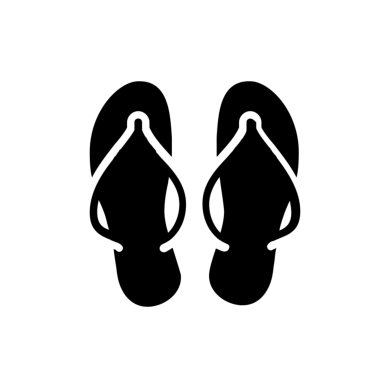

Image :  














                         .:i!:'                  `Ii!"                          
                        !*$$$$#!               '_%$$$@},                        
                      '?$$$$$$$$>             .{$$$$$$$@>                       
                     '$$$$$$$$$@"            <$$$$$$$$$$~                      
                    .}$$$$$$$$$$$?           '&$$$$$$$$$$$>                     
                    ~$$$$$$$$$$$$%'          I$$$$$$$$$$$$@,                    
                   ,@$$$$$$$$$$$$$;          -$$$$$$$$$$$$$/.                   
                  .{$$$$$$~^;*$$$$<         ./$$$$?",}$$$$$$i                   
                  ,$$$$$$_ :'"@$$$?         '&$$$/."".#$$$$$#.                  
                  -$$$$$$I`$+ #$$$         ^@$$$+ *@^?$$$$$$;                  
                 '&$$$$$$;`$_ *$$$*.        ,$$$$~ #$:_$$$$$$?                  
                 :$$$$$$/.I${ >$$$&.        :$$$@^.&$_^@$$$$$#.                 
    

In [ ]:
from mistralai.models.chat_completion import ChatMessage
from PIL import Image
import matplotlib.pyplot as plt


# Change Index From 0 and 16 number | From Valid Dataset
index = 5  ## Change 'index to try with multiple images


# Retrieve the content of the first message in the training data
content = train_data[index:][0]['messages']
image_in_ascii = content[0]['content']
content_prompt = train_data[index:][0]['messages'][-1]['content']

# Perform inference with the model
chat_response = client.chat(
    model=retrieved_jobs.fine_tuned_model,
    messages=[ChatMessage(role='user', content=content[0]['content'])]
)

def find_text_and_display_image(dataset, search_text):
    # Iterate through each example in the dataset
    for example in dataset['train']:
        if example['text'] == search_text:
            # Display the corresponding text
            print(f"{example['text']}")
            plt.imshow(example['image'])
            plt.axis('off')
            plt.show()
            return
    print("Image Don't Find")

# Search for a specific text and display the corresponding image
search_text = content_prompt
find_text_and_display_image(dataset, search_text)
print('Image : ', image_in_ascii)  #Print Image in ASCII
print('True Description :', content_prompt)
print('Model Description :', chat_response.choices[0].message.content)


## Wandb

##### FineTune Run in WandB : https://wandb.ai/zengdar/Mistral_Text2image?nw=nwuserzengdar